In [1]:
def plot_gi_per_category (data, type):
    fig, axs = plt.subplots(ncols=6, nrows=1, figsize=(18, 4), sharex=True, sharey=True)

    for gentr_class, ax in enumerate(axs.flatten()):
        class_data = data[data['gentrification_prediction_code'] == gentr_class]
        if class_data.empty:
            pass
        else:
            # Histogram
            # ax.hist(class_data['gi_n'], bins=2, color=plot_colors[gentr_class], density=True)

            counts, bins = np.histogram(class_data['gi_n'], bins=30)
            percentages = counts / counts.sum() * 100
            ax.bar(bins[:-1], percentages, width=np.diff(bins), align='edge', color=plot_colors[gentr_class])
                        
            # Compute mean and std
            mean = np.mean(class_data['gi_n'].values)
            std = np.std(class_data['gi_n'].values)
            
            # Add mean and std lines
            ax.axvline(mean, color='black', lw=2, linestyle='dashed')
            ax.axvline(mean - std, color='grey', lw=1, linestyle='dashed')
            ax.axvline(mean + std, color='grey', lw=1, linestyle='dashed')
            
            # Shade the area between mean ± std (full height of the plot)
            ax.axvspan(mean - std, mean + std, color='grey', alpha=0.3)
            ax.set_title(f"{reverse_mapping[gentr_class]} :\n{len(class_data)} {type} \n Mean = {mean:.1f}")
            ax.set_xlabel("Gentrification index")
            ax.set_ylabel("Percentage of listings")
    
            axs[5].axvline(np.mean(class_data['gi_n'].values), color=plot_colors[gentr_class], lw =3, linestyle='dashed')
            axs[5].axvspan(mean - std, mean + std, color=plot_colors[gentr_class], alpha=0.1)
    axs[5].set_title("All")
    fig.subplots_adjust(wspace=0.2)
    fig.savefig('../Figures/Manchester_LSOAs_GI_histogram.png', bbox_inches='tight')

def plot_simple_radar_GI(ax, indicators, all_vars, labels=None, color='blue', title='Radar Chart',
                         show_std=False, label_size=10, fixed_max=None, show_radial_labels=True):
    # Labels fallback
    if labels is None:
        labels = {var: var for var in all_vars}  # Use variable names if no labels provided

    # Calculate stats
    means = indicators[all_vars].mean().values.tolist()
    means += means[:1]
    angles = np.linspace(0, 2 * np.pi, len(all_vars), endpoint=False).tolist()
    angles += angles[:1]

    if show_std:
        stds = indicators[all_vars].std().values.tolist()
        stds += stds[:1]
        std_upper = np.array(means) + np.array(stds)
        std_lower = np.array(means) - np.array(stds)
        max_val = max(std_upper) * 1.1
    else:
        std_upper = std_lower = None
        max_val = max(means) * 1.1

    if fixed_max is not None:
        max_val = fixed_max

    # Set scale
    data_min = min(means if not show_std else std_lower)
    data_max = max(means if not show_std else std_upper)
    buffer = (data_max - data_min) * 0.1

    if fixed_max is not None:
        ax.set_ylim(-fixed_max, fixed_max)
    # ax.set_ylim(data_min - buffer, max_val)

    # Ticks
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([])

    if show_radial_labels:
        ticks = np.linspace(ax.get_ylim()[0], max_val, 5)
        ax.set_yticks(ticks)
        ax.set_yticklabels([f"{tick:.1f}" for tick in ticks], fontsize=9)
    else:
        ax.set_yticklabels([])

    # Main plot
    ax.plot(angles, means, color=color, linewidth=4)
    ax.scatter(angles, means, color=color, s=30)

    # Std shading
    if show_std and std_upper is not None:
        for i in range(10):
            alpha = 0.1
            lower = std_lower + (np.array(means) - std_lower) * (i / 10)
            upper = std_upper - (std_upper - np.array(means)) * (i / 10)
            ax.fill_between(angles, lower, upper, color=color, alpha=alpha)

    # Title
    ax.set_title(title, size=13, pad=30)

    # Simple labels (no groups)
    for i, var in enumerate(all_vars):
        angle = angles[i]
        label = labels.get(var, var)
    
        # Set a radius to push label out slightly
        radius = max_val * 0.9
    
        # Convert angle to degrees
        angle_deg = np.rad2deg(angle)
    
        # Set rotation mode
        if angle_deg >= 90 and angle_deg <= 270:
            rotation = angle_deg + 180  # Flip upside down
            alignment = 'right'
        else:
            rotation = angle_deg
            alignment = 'left'
    
        ax.text(angle, radius, label,
                ha=alignment, va='center',
                fontsize=label_size,
                fontweight='bold',
                rotation=0,
                rotation_mode='anchor')

In [2]:
import os
import re
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from scipy.stats import zscore, gaussian_kde
import matplotlib.patches as mpatches
import matplotlib.colors as colors
from datetime import datetime
import seaborn as sns
from shapely.geometry import Point
from geopandas import GeoDataFrame
from IPython.core.pylabtools import figsize
# from fontTools.varLib.interpolatableHelpers import matching_for_vectors
import folium
import branca.colormap as cm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sys

sys.path.insert(1,'../')
from PlottingFunctions import *

cmap = plt.get_cmap('plasma', 5)  # 5 discrete colors
plot_colors = [cmap(i) for i in range(5)]
plot_colors[4] = 'gold'

city='manchester'

### Get just Manchester LSOAs

In [3]:
lsoas =  gpd.read_file('../../../data/SpatialData/LSOAs_2011/LSOA_2011_EW_BSC_V4.shp')
manc_lads = ['Manchester', 'Rochdale', 'Bolton', 'Bury', 'Wigan', 'Oldham',  'Trafford', 'Salford', 'Tameside', 'Stockport']
manc_lads_pattern = '|'.join(manc_lads)
manchester_lsoas=lsoas[lsoas['LSOA11NMW'].str.contains(manc_lads_pattern)]

### Read in socioeconomic indicator data

In [4]:
indicators = pd.read_csv("../../../data/GentrificationIndex/SocioEconomicData/Eng_imputedV3.csv") # for the whole o England
# Get just for Manchester
indicators_manchester = indicators[indicators['LA_NAME'].str.contains(manc_lads_pattern)].copy()
indicators_manchester = indicators_manchester.rename(columns={"LSOA": 'LSOA11CD'})
del indicators_manchester['Churn_2020']
indicators_manchester.reset_index(inplace=True, drop=True)
len(indicators_manchester)

1673

## Get gentrification scores, convert string to categorical

In [5]:
base_dir = os.path.expanduser(f"../../../data/AirbnbData/airbnb-{city}/")
gentrification_cat_df = pd.read_csv(base_dir + 'airbnb_gentrification_scores_new_02.csv')
mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
reverse_mapping = {0:'Na',1:'Undeveloped', 2:'Emerging', 3:'Gentrifying', 4: 'Established'}
gentrification_cat_df['gentrification_prediction_code'] = gentrification_cat_df['gentrification_prediction'].map(mapping)
# Remove rows with an error
gentrification_cat_df = gentrification_cat_df[gentrification_cat_df['explanation'] != 'ERROR']

In [6]:
# gentrification_cat_df['gentrification_prediction'] = gentrification_cat_df['gentrification_prediction'].astype(str)
# gentrification_cat_df[gentrification_cat_df['gentrification_prediction'] == 'nan']

### Convert to a geodataframe

In [7]:
gentrification_cat_df['geometry'] = gentrification_cat_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
gentrification_cat_df = gpd.GeoDataFrame(gentrification_cat_df, geometry='geometry', crs="EPSG:4326")
gentrification_cat_df = gentrification_cat_df[['LSOA11NM', 'gentrification_prediction_code']]
gentrification_cat_df = gentrification_cat_df.merge(manchester_lsoas[['LSOA11NM', 'LSOA11CD']], on='LSOA11NM', how='left')

### Find the most common score in each LSOA

In [8]:
lsoa_scores = pd.DataFrame({'gentrification_prediction_code': gentrification_cat_df.groupby("LSOA11CD")["gentrification_prediction_code"].agg(lambda x: pd.Series.mode(x).iloc[0]), 
              'count':gentrification_cat_df.groupby("LSOA11CD")["gentrification_prediction_code"].count()})
lsoa_scores.reset_index(inplace=True)

### Join the LSOA scores to the socio-economic indicators

In [9]:
indicators_manchester = indicators_manchester.merge(lsoa_scores, on='LSOA11CD', how='right')
indicators_manchester.sort_values(by='gentrification_prediction_code', inplace=True)

### Join the gentrification index data

In [10]:
g_index = pd.read_csv("../../../data/GentrificationIndex/ManchesterIndex/manc_index.csv") 
# g_index_cols_to_join = ['LSOA11CD', 'gi_n', 'rmd_z', 'house_price_z', 'BME_z', 'churn_z', 'wage_change_z',
#     'rmd', 'hp_pc_change', 'poc_ppt', 'chn2013', 'wage_change']

g_index_cols_to_join = ['LSOA11CD', 'rmd', 'hp_pc_change', 'poc_ppt', 'chn2013', 'wage_change', 'gi_n' ]

# Merge the specified columns into indicators_manchester
indicators_manchester = indicators_manchester.merge( g_index[g_index_cols_to_join],on='LSOA11CD', how='left')

# remove LSOA from the list (for later use)
del g_index_cols_to_join[0]

### Scale the indicators - per LSOA

In [11]:
numeric_cols = indicators_manchester.columns
numeric_cols = numeric_cols.drop(['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code', 'count', 'gi_n'])

standard_scaler = StandardScaler()
scaled_standard = standard_scaler.fit_transform(indicators_manchester[numeric_cols])

# Convert scaled values back to DataFrame and concatenate with original non-numeric columns
scaled_standard_df = pd.DataFrame(scaled_standard, columns=numeric_cols)
indicators_manchester_standard = pd.concat([indicators_manchester[['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code', 'count', 'gi_n']], scaled_standard_df], axis=1)

### Get category for each listing, with socio-economic and GI data

In [12]:
gentrification_cat_df = gentrification_cat_df.merge(g_index[['gi_n', 'LSOA11CD','rmd', 'hp_pc_change', 'poc_ppt', 'chn2013', 'wage_change']],on='LSOA11CD', how='left')
numeric_cols = ['rmd', 'hp_pc_change', 'poc_ppt', 'chn2013', 'wage_change']
scaled_standard = standard_scaler.fit_transform(gentrification_cat_df[numeric_cols])

# Convert scaled values back to DataFrame and concatenate with original non-numeric columns
scaled_standard_df = pd.DataFrame(scaled_standard, columns=numeric_cols)
gentrification_cat_df = pd.concat([gentrification_cat_df[['LSOA11CD',  'gentrification_prediction_code','gi_n']], scaled_standard_df], axis=1)

## Rose plots - with (mode) values per LSOA

In [13]:
cols = ['rmd', 'hp_pc_change', 'poc_ppt', 'chn2013', 'wage_change']

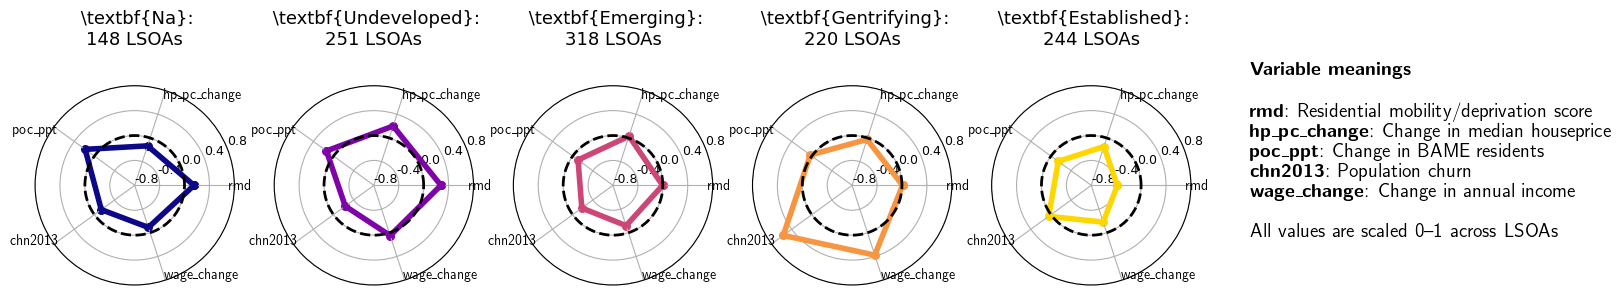

In [14]:
fig, axs = plt.subplots(subplot_kw={'projection': 'polar'}, ncols=6, nrows=1, figsize=(18, 8), sharex=True, sharey=True)
fixed_max = 0.8
plt.rcParams['text.usetex'] = True

for gentr_class, ax in enumerate(axs.flatten()):
    if gentr_class < 5:
        class_data = indicators_manchester_standard[
            indicators_manchester_standard['gentrification_prediction_code'] == gentr_class]
        
        if not class_data.empty:
            key = [k for k, v in mapping.items() if v == gentr_class][0]
            plot_simple_radar_GI(
                ax, class_data, cols,
                color=plot_colors[gentr_class],
#                 title=f"'{key}':\n{len(class_data)} LSOAs",
                title=f" \\textbf{{{key}}}:\n{len(class_data)} LSOAs",
                show_std=False,
                fixed_max=fixed_max
            )
        ax.plot(np.linspace(0, 2 * np.pi, 100), np.zeros(100),
                color='black', linewidth=2, linestyle='dashed')
    else:
        # --- Fill last subplot (axs[5]) with variable explanations ---
        ax.set_axis_off()
        fontsize=30
        fig.text(
        0.8, 0.65,  # x=0.85, y=0.95 in figure coordinates
        "\n".join([
            "\\textbf{Variable meanings}",
            "",
            f"\\textbf{{{cols[0]}}}: Residential mobility/deprivation score",
            f"\\textbf{{{cols[1]}}}: Change in median houseprice",
            f"\\textbf{{{cols[2]}}}: Change in BAME residents",
            f"\\textbf{{{cols[3]}}}: Population churn",
            f"\\textbf{{{cols[4]}}}: Change in annual income",
            "",
            "All values are scaled 0–1 across LSOAs"
        ]),
        ha='left', va='top',
        fontsize=14
    )

fig.savefig('../Figures/Manchester_LSOAs_GI_radarplot.png', bbox_inches='tight')


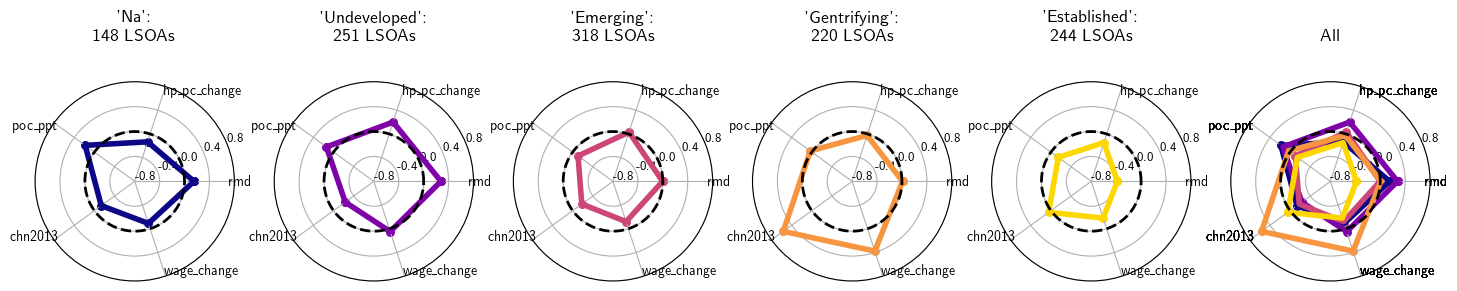

In [15]:
fig, axs = plt.subplots(subplot_kw={'projection': 'polar'}, ncols=6, nrows=1, figsize=(18, 8), sharex=True, sharey=True)
fixed_max = 0.8
for gentr_class, ax in enumerate(axs.flatten()):
    class_data = indicators_manchester_standard[
        indicators_manchester_standard['gentrification_prediction_code'] == gentr_class]
    
    if class_data.empty:
        #ax.set_axis_off()
        pass
    else:
        key = [k for k, v in mapping.items() if v == gentr_class][0]
        plot_simple_radar_GI( ax, class_data, cols,
            color=plot_colors[gentr_class],  title=f"'{key}':\n{len(class_data)} LSOAs", show_std=False, fixed_max=fixed_max)
        plot_simple_radar_GI( axs[5], class_data, cols,
            color=plot_colors[gentr_class],  title="All", show_std=False, fixed_max=fixed_max)
    ax.plot(np.linspace(0, 2 * np.pi, 100), np.zeros(100), color='black', linewidth=2, linestyle='dashed')
fig.savefig('../Figures/Manchester_LSOAs_GI_radarplot.png', bbox_inches='tight')
# plot_gi_per_category(indicators_manchester_standard, 'LSOAs')

## Rose plots - including values for all listings

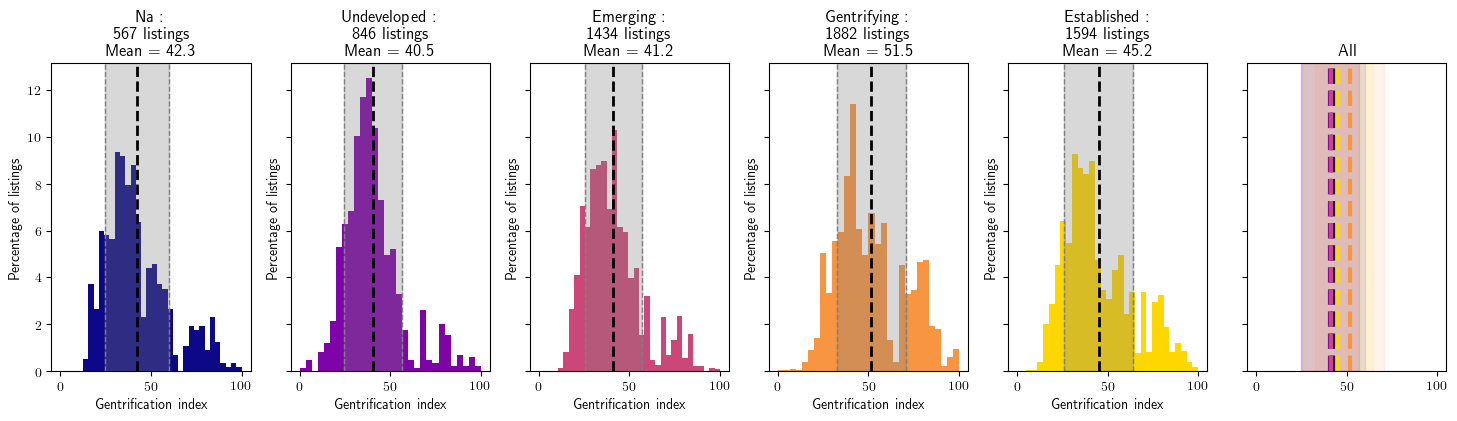

In [16]:
# fig, axs = plt.subplots(subplot_kw={'projection': 'polar'}, ncols=6, nrows=1, figsize=(18, 8), sharex=True, sharey=True)
# fixed_max = 0.5
# for gentr_class, ax in enumerate(axs.flatten()):
#     class_data = gentrification_cat_df[
#             gentrification_cat_df['gentrification_prediction_code'] == gentr_class]
    
#     if class_data.empty:
#         #ax.set_axis_off()
#         pass
#     else:
#         key = [k for k, v in mapping.items() if v == gentr_class][0]
#         plot_simple_radar_GI( ax, class_data, cols,
#             color=plot_colors[gentr_class],  title=f"'{key}':\n{len(class_data)} listings", show_std=False, fixed_max=fixed_max)
#         plot_simple_radar_GI( axs[5], class_data, cols,
#             color=plot_colors[gentr_class],  title="All", show_std=False, fixed_max=fixed_max)
#     ax.plot(np.linspace(0, 2 * np.pi, 100), np.zeros(100), color='black', linewidth=2, linestyle='dashed')
    
plot_gi_per_category(gentrification_cat_df, 'listings')    

### Alternative plotting option: Boxplots

In [17]:
# fig, axs = plt.subplots(ncols=6, nrows=1, figsize=(18, 4), sharex=True, sharey=True)

# for gentr_class, ax in enumerate(axs.flatten()):
#     class_data = data[
#         data['gentrification_prediction_code'] == gentr_class]
#     if class_data.empty:
#         pass
#     else:
#         # Histogram
#         ax.hist(class_data['gi_n'], bins=26, color=plot_colors[gentr_class])
        
#         # Compute mean and std
#         mean = np.mean(class_data['gi_n'].values)
#         std = np.std(class_data['gi_n'].values)
        
#         # Add mean and std lines
#         ax.axvline(mean, color='black', lw=2, linestyle='dashed')
#         ax.axvline(mean - std, color='grey', lw=1, linestyle='dashed')
#         ax.axvline(mean + std, color='grey', lw=1, linestyle='dashed')
        
#         # Shade the area between mean ± std (full height of the plot)
#         ax.axvspan(mean - std, mean + std, color='grey', alpha=0.3)
#         ax.set_title(f"{reverse_mapping[gentr_class]}")
#         ax.set_xlabel("Gentrification index")
#         ax.set_ylabel("Count of listings")

#         axs[5].axvline(np.mean(class_data['gi_n'].values), color=plot_colors[gentr_class], lw =1, linestyle='solid')
# axs[5].set_title("All")

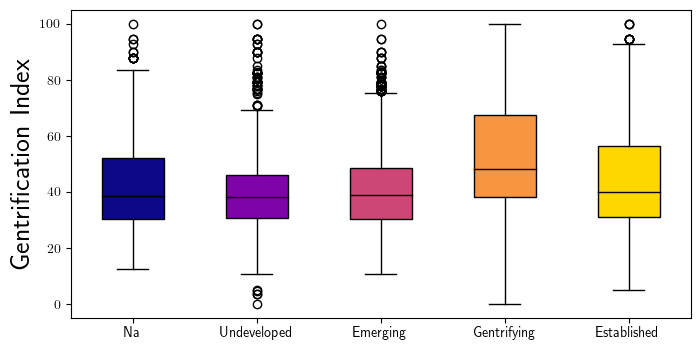

In [22]:
grouped_data = [
    gentrification_cat_df[gentrification_cat_df['gentrification_prediction_code'] == i]['gi_n']
    for i in sorted(gentrification_cat_df['gentrification_prediction_code'].unique())]

colors = plot_colors  # Customize as needed
labels = [f'{reverse_mapping[i]}' for i in range(len(grouped_data))]

fig, ax = plt.subplots(figsize=(10, 6))
box = ax.boxplot(grouped_data, labels=labels, patch_artist=True)  # <– Important: patch_artist=True

# Color each box
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(1)

# Optionally color medians, whiskers, etc.
for median in box['medians']:
    median.set_color('black')

# ax.set_xlabel('Gentrification Class')
ax.set_ylabel('Gentrification Index', fontsize=20)
plt.show()
fig.savefig('../Figures/Manchester_gi_boxplot.png', bbox_inches='tight')

### Old code - rose plots - also plotting the standard deviation

In [19]:
# fig, axs = plt.subplots(subplot_kw={'projection': 'polar'}, ncols=5, nrows=1, figsize=(18, 8), sharex=True, sharey=True)

# for gentr_class, ax in enumerate(axs.flatten()):
#     ax.plot(np.linspace(0, 2 * np.pi, 100), np.zeros(100), color='black', linewidth=1)
#     class_data = indicators_manchester_standard[
#         indicators_manchester_standard['score'] == gentr_class]
#     if class_data.empty:
#         ax.set_axis_off()
#     else:
#         key = [k for k, v in mapping.items() if v == gentr_class][0]
#         plot_flexible_radar( ax, class_data, numeric_cols,
#             color=plot_colors[gentr_class],  title=f"'{key}':\n{len(class_data)} LSOAs", show_std=True, fixed_max=2)

### Spatial plot